In [20]:
import sys

sys.path.append("../")

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [23]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [24]:
%config InlineBackend.figure_format = 'retina'

In [25]:
EXPERIMENT_DIR = "lilo_arxiv_v1"
EXPERIMENT_NAME = "runs_multi"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [26]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_dir=EXPERIMENT_DIR,
    experiment_name=EXPERIMENT_NAME,
    experiment_types=[
        "baseline_dreamcoder", 
        "gpt_solver", 
        "gpt_solver_search", 
        "gpt_solver_stitch", 
        "gpt_solver_stitch_namer", 
        "gpt_solver_stitch_namer_hybrid_dsl", 
        "gpt_solver_stitch_namer_search"
    ],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../lilo_arxiv_v1/outputs/runs_multi
Available domains: ['re2', 'clevr', 'logo']


In [27]:
# Key results
# analyzer = SynthesisExperimentAnalyzer(
#     experiment_dir=EXPERIMENT_DIR,
#     experiment_name=EXPERIMENT_NAME,
#     experiment_types=[
#         "baseline_dreamcoder", 
#         "gpt_solver_search", 
#         "gpt_solver_stitch_namer_search"
#     ],
#     allow_incomplete_results=True,
#     compute_likelihoods=COMPUTE_LIKELIHOODS,
#     batch_size = 96,
#     seeds = [111, 222, 333],
# )

# Tasks solved vs. LAPS iteration

In [28]:
df_results = analyzer.get_synthesis_summary()
df_results = analyzer.format_dataframe_camera(df_results)

In [29]:
df_results

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
588,REGEX,DreamCoder,111,0,test,71,14.2
592,REGEX,DreamCoder,111,3,test,139,27.8
596,REGEX,DreamCoder,111,6,test,219,43.8
600,REGEX,DreamCoder,111,9,test,224,44.8
604,REGEX,DreamCoder,111,12,test,231,46.2
...,...,...,...,...,...,...,...
539,LOGO,NaN,333,5,train,74,37.0
541,LOGO,NaN,333,6,train,79,39.5
542,LOGO,NaN,333,7,train,81,40.5
543,LOGO,NaN,333,8,train,83,41.5


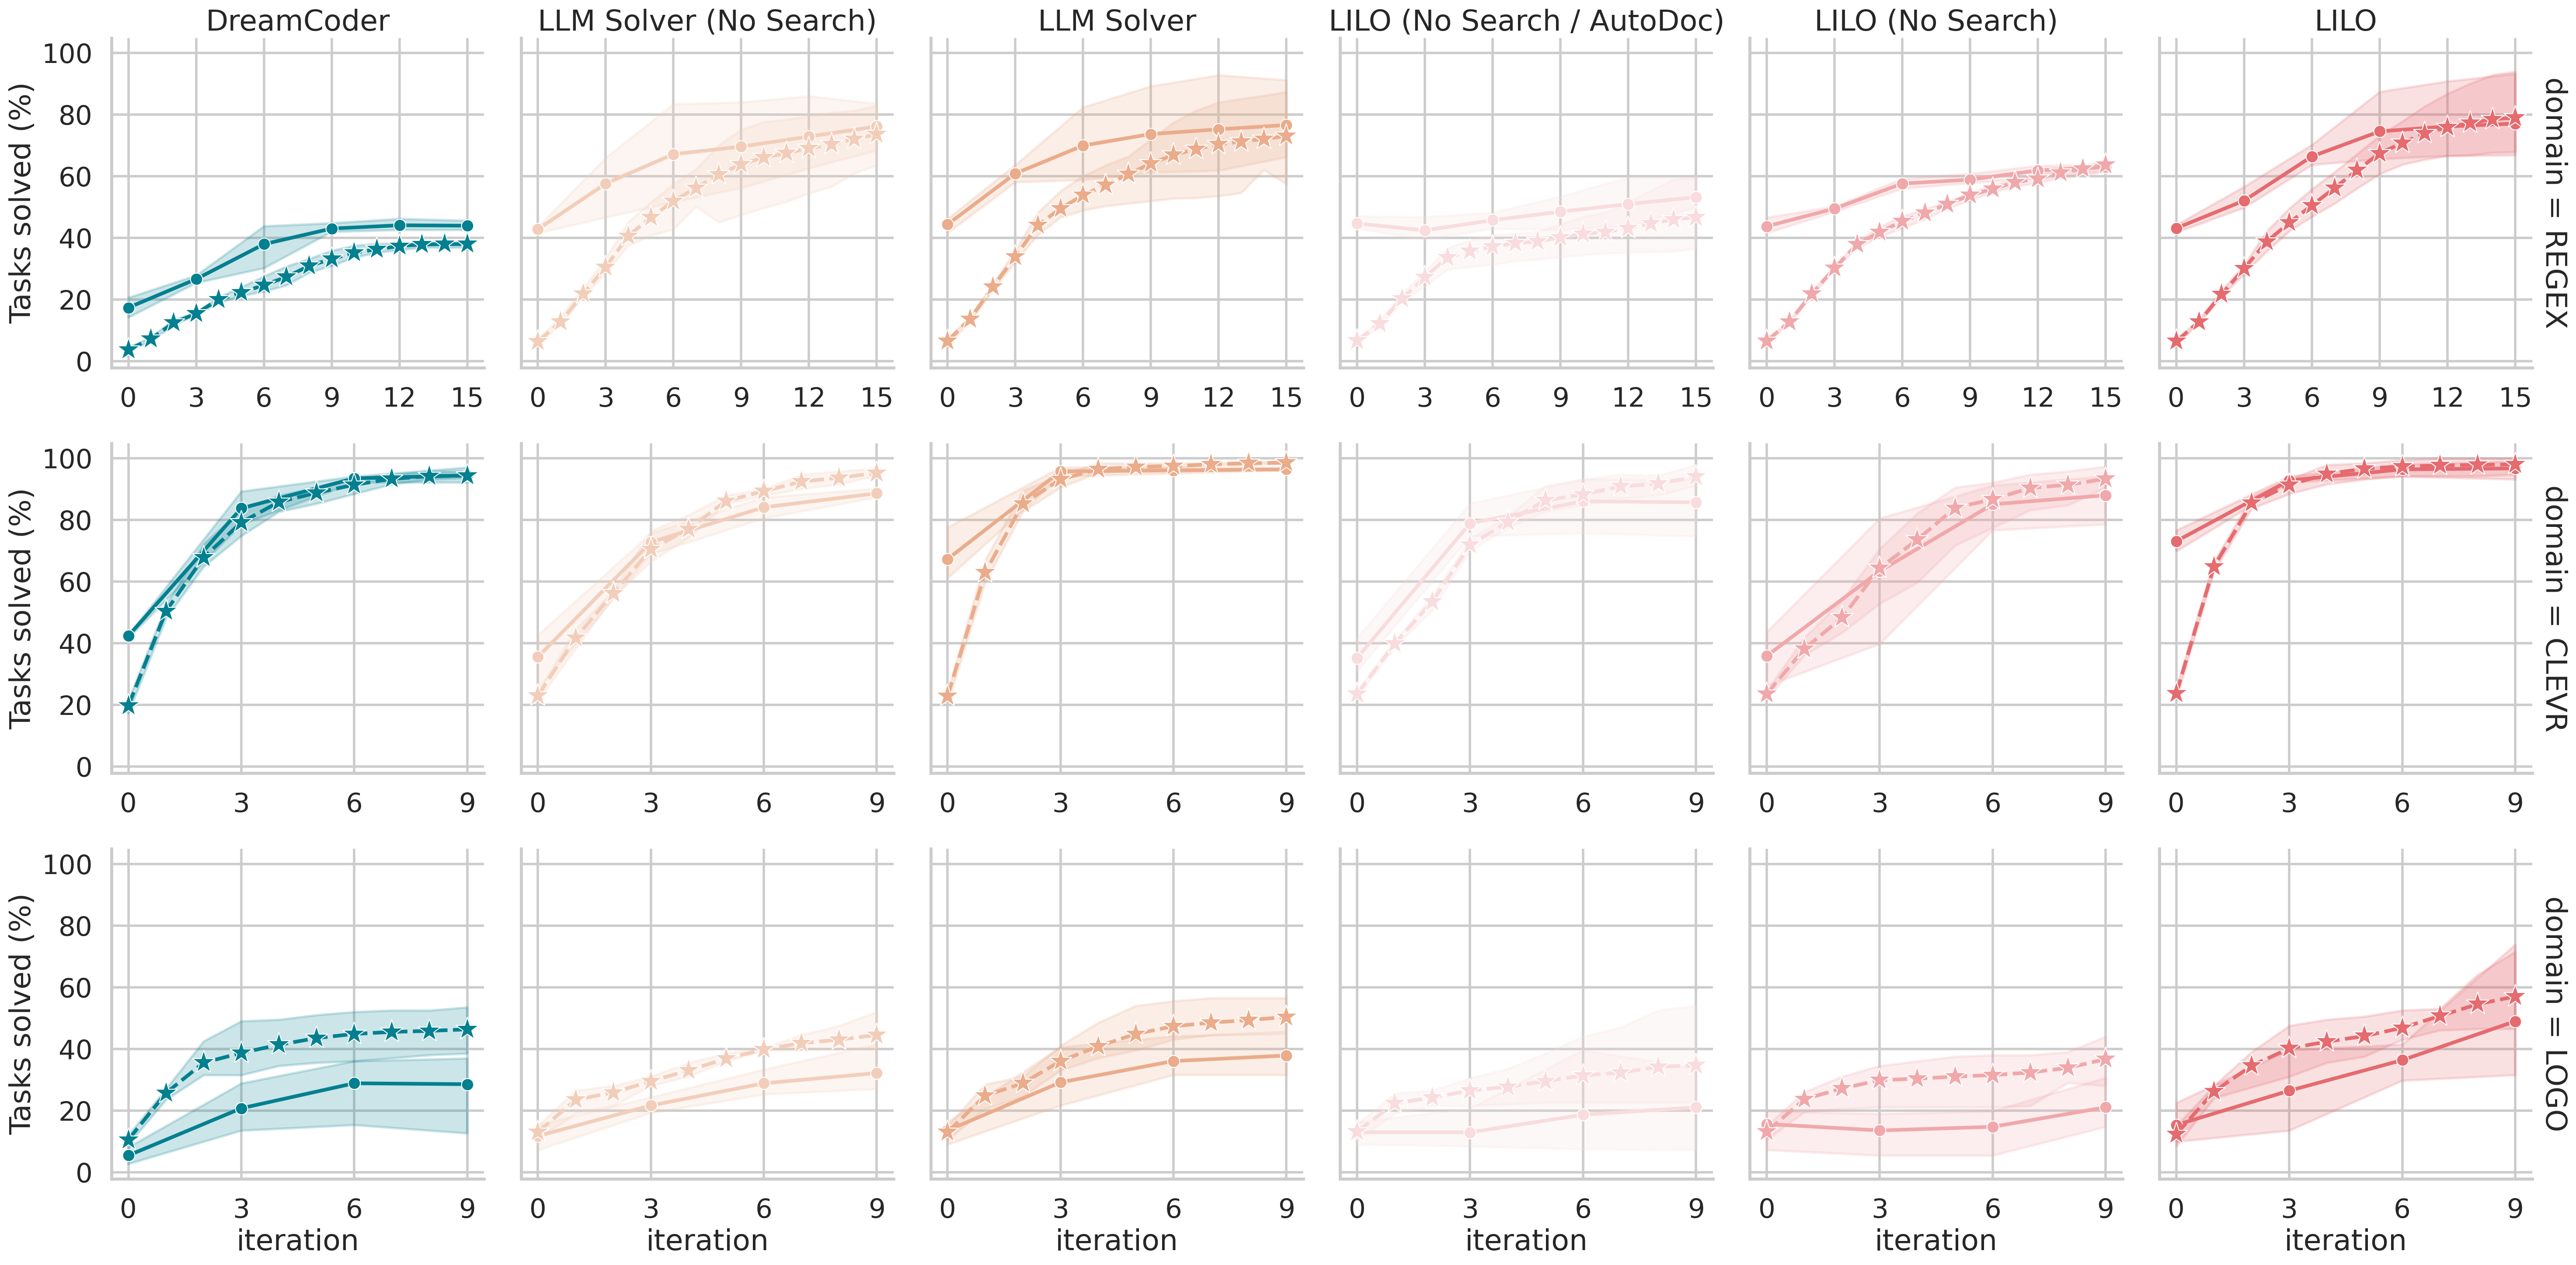

In [30]:
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results,
        kind="line",
        row="domain",
        col=analyzer.COL_NAMES_CAMERA["experiment_type"],
        x="iteration",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        style="split",
        markers=[".", "*"],
        markersize=20,
        # errorbar="se",
        # col_order=["train", "test"],
        row_order = [d for d in analyzer.DOMAIN_NAMES_CAMERA.values() if d in df_results.domain.unique()],
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=False,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    for ax in g.axes[0]:
        ax.set_xticks(np.arange(0, 16, 3))
    for ax in g.axes[1]:
        ax.set_xticks(np.arange(0, 10, 3))
    for ax in g.axes[2]:
        ax.set_xticks(np.arange(0, 10, 3))
        
    # sns.move_legend(g, "lower center")
        
    # plt.savefig(os.path.join(FIGURES_DIR, "main_results.pdf"), dpi=300, bbox_inches="tight")

# Main results table

In [31]:
df_results_test = df_results.query("split == 'test'")
grouped = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
    "seed",
], as_index=False)

def _get_final_iteration(group):
    final_iteration = group["iteration"].max().item()
    return group[group["iteration"] == final_iteration]

df_results_test = grouped.apply(_get_final_iteration).reset_index(drop=True)
df_results_test

,domain,Model,seed,iteration,split,n_solved,Tasks solved (%)
0,REGEX,DreamCoder,111,15,test,228,45.600000
1,REGEX,DreamCoder,222,15,test,213,42.600000
2,REGEX,DreamCoder,333,15,test,218,43.600000
3,REGEX,LLM Solver (No Search),111,15,test,350,70.000000
4,REGEX,LLM Solver (No Search),222,15,test,450,90.000000
5,REGEX,LLM Solver (No Search),333,15,test,342,68.400000
6,REGEX,LLM Solver,111,15,test,362,72.400000
7,REGEX,LLM Solver,222,15,test,456,91.200000
8,REGEX,LLM Solver,333,15,test,331,66.200000
9,REGEX,LILO (No Search / AutoDoc),111,15,test,249,49.800000


In [32]:
df_metrics_test = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
]) \
[[
    analyzer.COL_NAMES_CAMERA["percent_solved"]
]] \
.agg(["mean", "max", "std"])

df_metrics_test = df_metrics_test.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=0)
df_metrics_test

Tasks solved (%)                      
                                              mean        max        std
domain Model                                                            
REGEX  DreamCoder                        43.933333  45.600000   1.527525
       LLM Solver (No Search)            76.133333  90.000000  12.035503
       LLM Solver                        76.600000  91.200000  13.018448
       LILO (No Search / AutoDoc)        53.200000  59.400000   5.377732
       LILO (No Search)                  62.933333  63.800000   1.501111
       LILO                              77.066667  93.200000  14.144021
CLEVR  DreamCoder                        94.498382  97.087379   2.443312
       LLM Solver (No Search)            88.673139  90.291262   1.483034
       LLM Solver                        96.440129  97.087379   0.560534
       LILO (No Search / AutoDoc)        85.760518  93.203883   9.724906
       LILO (No Search)                  88.025890  94.174757   8.257185
       LILO                              96.763754  99.029126   3.120923
LOGO   DreamCoder                        28.528529  36.936937  13.790946
       LLM Solver (No Search)            32.132132  41.441441   8.074672
       LLM Solver                        37.837838  45.045045   6.801653
       LILO (No Search / AutoDoc)        21.021021  45.045045  20.883290
       LILO (No Search)                  21.021021  30.630631   9.463034
       LILO                              48.948949  73.873874  22.147020

In [33]:
# Reorder column levels
df_metrics_test_final = df_metrics_test.reset_index().pivot(index="Model", columns="domain").reorder_levels(order=[0, 2, 1], axis="columns")

# Reorder columns
multiindex = df_metrics_test_final.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["max", "mean", "std"], level=2)[0]

df_metrics_test_final = df_metrics_test_final.reindex(columns=multiindex)
df_metrics_test_final.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_metrics_test_final.index]
df_metrics_test_final = df_metrics_test_final.reindex(experiment_types)

# Remove 'Model'
df_metrics_test_final.index.name = None

# Round numbers
df_metrics_test_final = df_metrics_test_final.round(2)

# Output to LaTeX
df_metrics_test_final.to_latex("main_results_table.tex")

df_metrics_test_final

Tasks solved (%)                                    \
                                      REGEX                CLEVR                
                                        max   mean    std    max   mean   std   
DreamCoder                             45.6  43.93   1.53  97.09  94.50  2.44   
LLM Solver (No Search)                 90.0  76.13  12.04  90.29  88.67  1.48   
LLM Solver                             91.2  76.60  13.02  97.09  96.44  0.56   
LILO (No Search / AutoDoc)             59.4  53.20   5.38  93.20  85.76  9.72   
LILO (No Search)                       63.8  62.93   1.50  94.17  88.03  8.26   
LILO                                   93.2  77.07  14.14  99.03  96.76  3.12   

                                                 
                             LOGO                
                              max   mean    std  
DreamCoder                  36.94  28.53  13.79  
LLM Solver (No Search)      41.44  32.13   8.07  
LLM Solver                  45.05  37.84   6.80  
LILO (No Search / AutoDoc)  45.05  21.02  20.88  
LILO (No Search)            30.63  21.02   9.46  
LILO                        73.87  48.95  22.15

# Runtime metrics

In [34]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "split"]).time_elapsed.agg("mean")

domain  experiment_type                 model_type           model_fn                      split
clevr   baseline_dreamcoder             amortized_synthesis  infer_programs_for_tasks      test      627.410529
                                                                                           train     626.392419
                                                             optimize_model_for_frontiers  train     639.112597
                                        grammar              infer_programs_for_tasks      train     602.131269
        gpt_solver                      llm_solver           infer_programs_for_tasks      test      744.879183
                                                                                                       ...     
re2     gpt_solver_stitch_namer_search  amortized_synthesis  infer_programs_for_tasks      train     956.806781
                                                             optimize_model_for_frontiers  train     262.684452
       

In [35]:
df_infer_programs = df_runtime.query("model_fn == 'infer_programs_for_tasks'").query("model_type != 'grammar'")

# Remove outliers
df_infer_programs = df_infer_programs.query("time_elapsed > 300.0")


df_infer_programs

,curr_iteration,model_type,model_fn,split,time_start,time_end,time_elapsed,domain,experiment_type,seed,iteration
2,0,amortized_synthesis,infer_programs_for_tasks,train,2023-04-28 22:24:19.571785472+00:00,2023-04-28 22:41:05.207317504+00:00,1005.635532,re2,baseline_dreamcoder,111,0
3,0,amortized_synthesis,infer_programs_for_tasks,test,2023-04-28 22:41:05.210528768+00:00,2023-04-29 00:08:40.567719168+00:00,5255.357190,re2,baseline_dreamcoder,111,0
5,1,amortized_synthesis,infer_programs_for_tasks,train,2023-04-29 00:13:29.896112384+00:00,2023-04-29 00:30:25.199052032+00:00,1015.302940,re2,baseline_dreamcoder,111,1
7,2,amortized_synthesis,infer_programs_for_tasks,train,2023-04-29 00:34:49.866311680+00:00,2023-04-29 00:51:45.249414912+00:00,1015.383103,re2,baseline_dreamcoder,111,2
9,3,amortized_synthesis,infer_programs_for_tasks,train,2023-04-29 00:56:06.303152384+00:00,2023-04-29 01:13:01.237486592+00:00,1014.934334,re2,baseline_dreamcoder,111,3
...,...,...,...,...,...,...,...,...,...,...,...
1998,8,amortized_synthesis,infer_programs_for_tasks,train,2023-05-09 15:56:04.268782336+00:00,2023-05-09 16:26:23.548738560+00:00,1819.279956,logo,gpt_solver_stitch_namer_search,333,8
2000,9,llm_solver,infer_programs_for_tasks,train,2023-05-09 19:46:34.041540352+00:00,2023-05-09 19:55:45.109794304+00:00,551.068254,logo,gpt_solver_stitch_namer_search,333,9
2002,9,amortized_synthesis,infer_programs_for_tasks,train,2023-05-09 20:02:59.027871488+00:00,2023-05-09 20:33:13.493095424+00:00,1814.465224,logo,gpt_solver_stitch_namer_search,333,9
2003,9,llm_solver,infer_programs_for_tasks,test,2023-05-09 20:33:13.494556160+00:00,2023-05-09 20:46:42.105857024+00:00,808.611301,logo,gpt_solver_stitch_namer_search,333,9


In [36]:
analyzer.format_dataframe_camera(df_infer_programs)

,curr_iteration,model_type,model_fn,split,time_start,time_end,time_elapsed,domain,Model,seed,iteration
3,0,amortized_synthesis,infer_programs_for_tasks,test,2023-04-28 22:41:05.210528768+00:00,2023-04-29 00:08:40.567719168+00:00,5255.357190,REGEX,DreamCoder,111,0
10,3,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 01:13:01.245009920+00:00,2023-04-29 02:29:59.210052352+00:00,4617.965042,REGEX,DreamCoder,111,3
17,6,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 03:33:58.367144192+00:00,2023-04-29 04:41:22.761961472+00:00,4044.394817,REGEX,DreamCoder,111,6
24,9,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 05:46:13.461995008+00:00,2023-04-29 06:52:22.957523456+00:00,3969.495528,REGEX,DreamCoder,111,9
31,12,amortized_synthesis,infer_programs_for_tasks,test,2023-04-29 07:57:26.422527488+00:00,2023-04-29 08:59:17.856697088+00:00,3711.434170,REGEX,DreamCoder,111,12
...,...,...,...,...,...,...,...,...,...,...,...
1850,5,llm_solver,infer_programs_for_tasks,train,2023-05-08 23:46:26.632926464+00:00,2023-05-09 00:02:09.721152512+00:00,943.088226,LOGO,NaN,333,5
1852,6,llm_solver,infer_programs_for_tasks,train,2023-05-09 00:03:03.896557568+00:00,2023-05-09 00:16:45.366617600+00:00,821.470060,LOGO,NaN,333,6
1855,7,llm_solver,infer_programs_for_tasks,train,2023-05-09 00:38:58.730871296+00:00,2023-05-09 00:55:35.961236480+00:00,997.230365,LOGO,NaN,333,7
1857,8,llm_solver,infer_programs_for_tasks,train,2023-05-09 00:56:36.893556992+00:00,2023-05-09 01:09:28.775816960+00:00,771.882260,LOGO,NaN,333,8


## Wall clock time figure

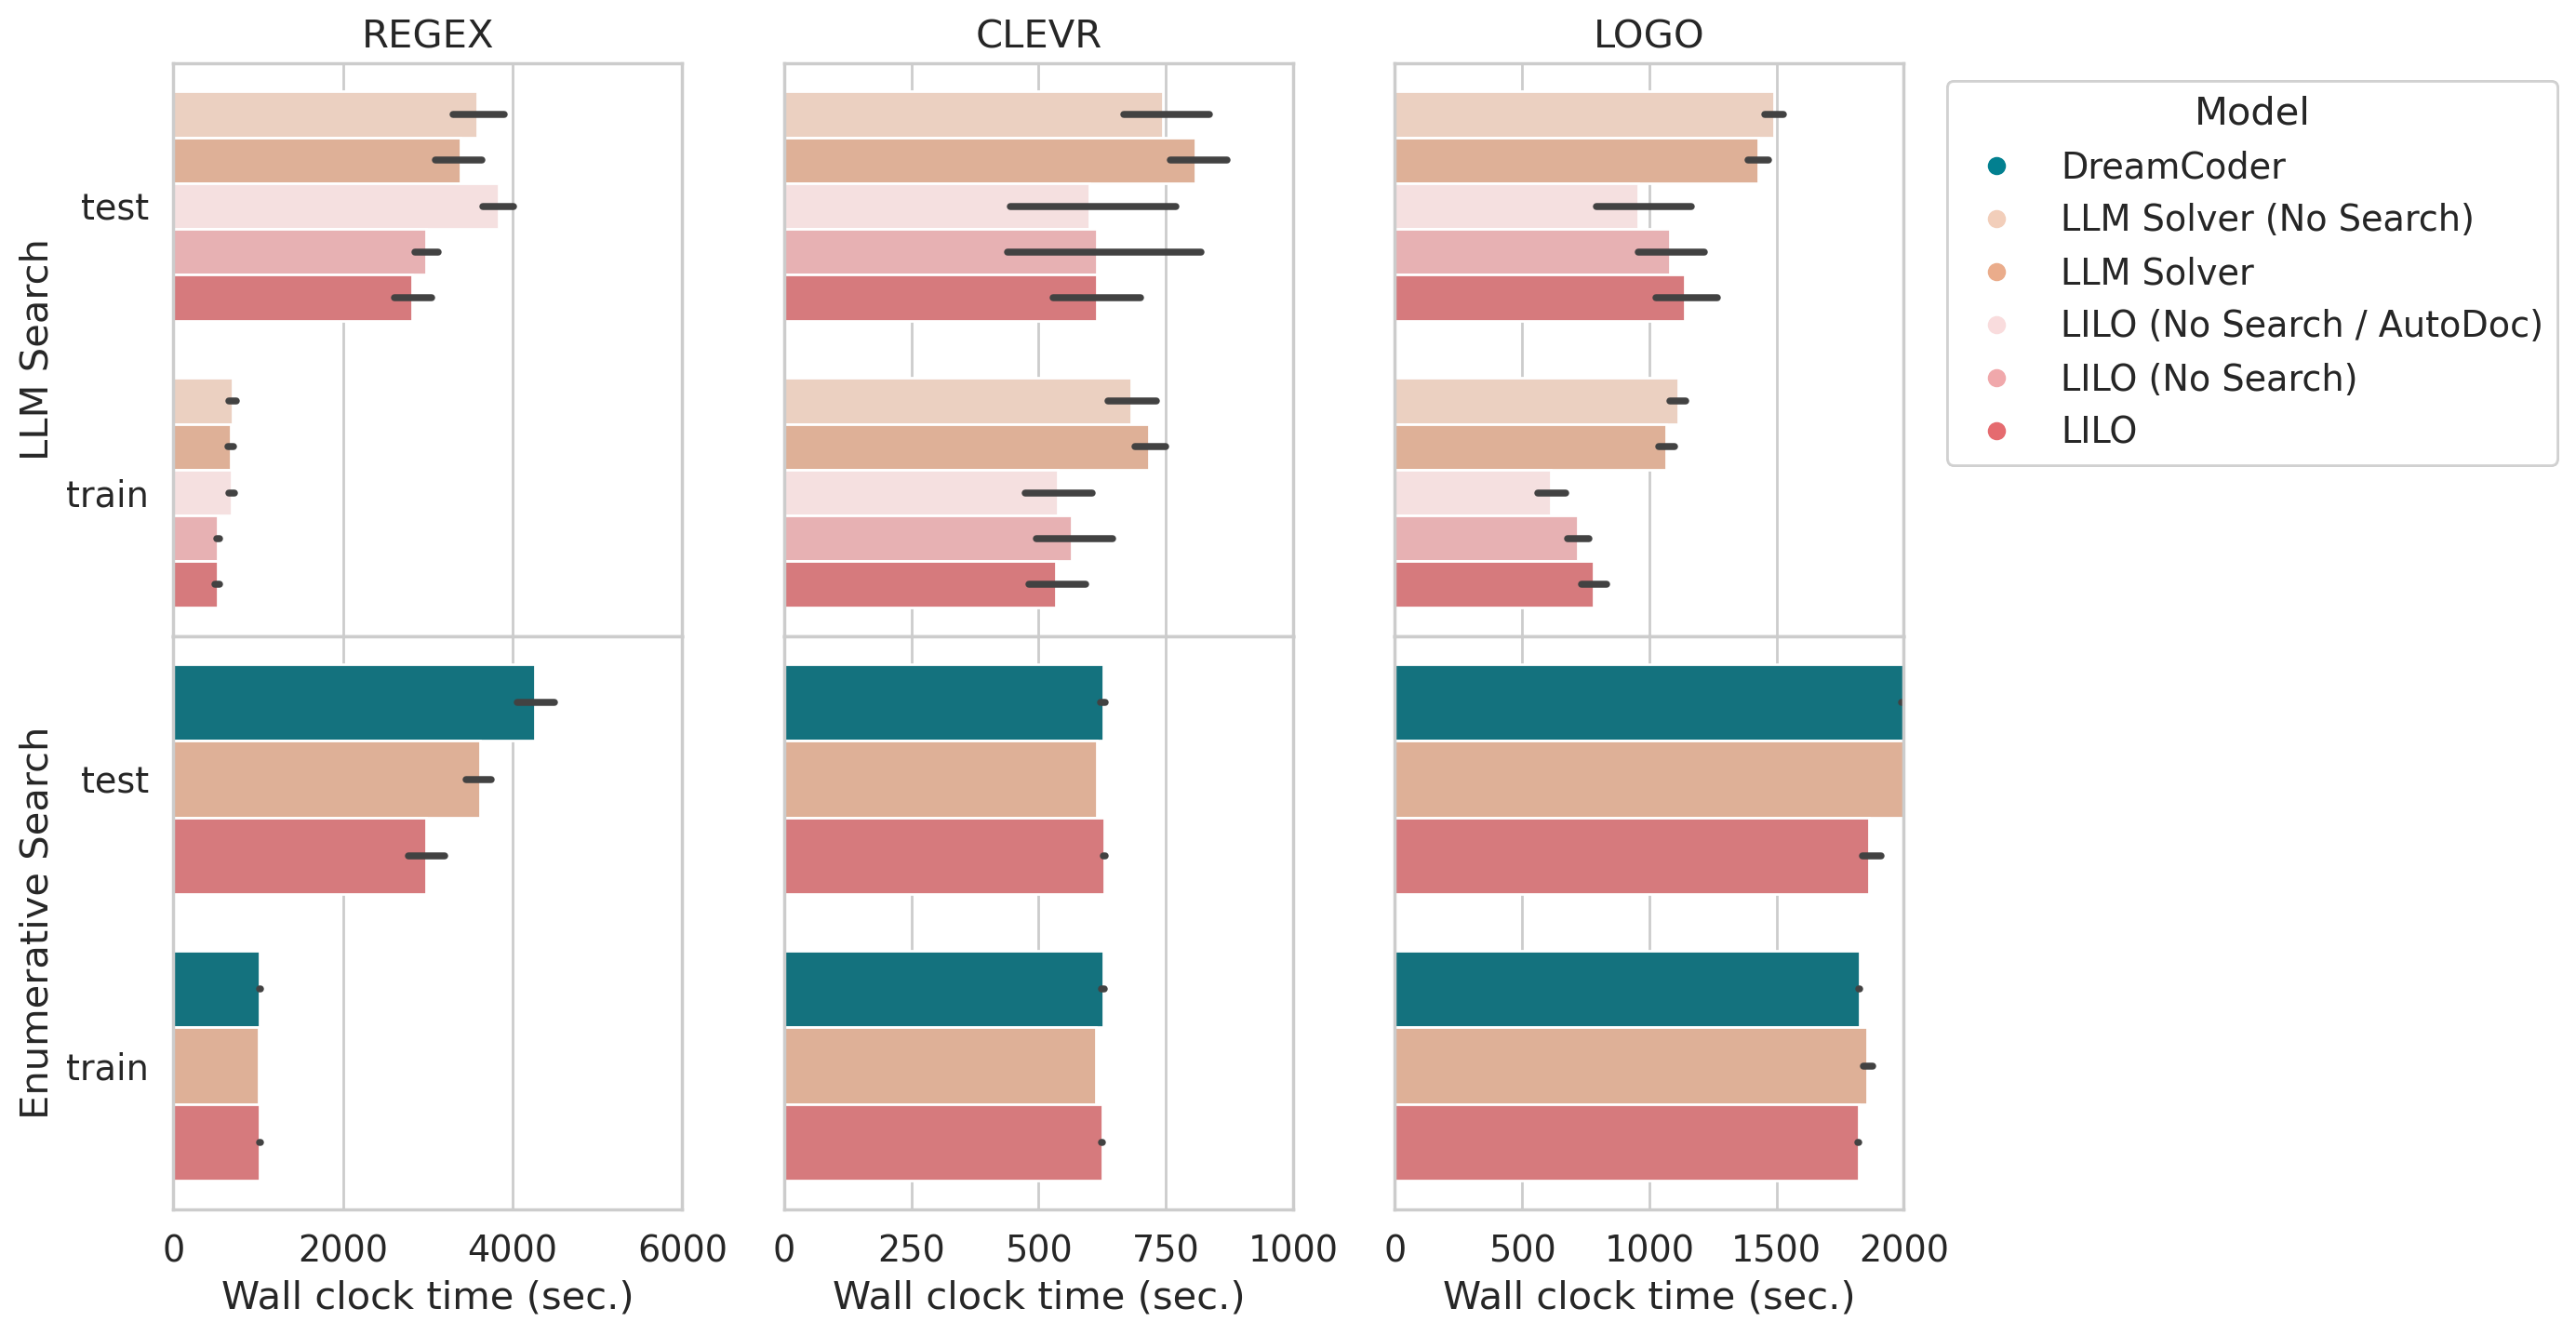

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# First plot
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False)  # Create subplots with shared x-axis
plt.subplots_adjust(hspace=0.)  # Adjust vertical spacing between subplots

for i, domain in enumerate(analyzer.domains):

    # Plot 1
    ax1 = sns.barplot(
        data=analyzer.format_dataframe_camera(df_infer_programs.query("model_type == 'llm_solver'").query(f"domain == '{domain}'")), 
        ax=axes[0][i],  # Specify the first subplot
        y="split",
        x="time_elapsed", 
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    )
    ax1.set(xlabel=None)
    ax1.set_xticks(ticks=ax1.get_xticks(), labels=[])
    
    ax1.legend_.remove()
    
    ax1.set_title(analyzer.DOMAIN_NAMES_CAMERA[domain])

    # Plot 2
    ax2 = sns.barplot(
        data=analyzer.format_dataframe_camera(df_infer_programs.query("model_type == 'amortized_synthesis'").query(f"domain == '{domain}'")), 
        ax=axes[1][i],  # Specify the second subplot
        y="split",
        x="time_elapsed", 
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    )
    
    ax2.set(xlabel="Wall clock time (sec.)", xlim=ax1.get_xlim())
    
    ax2.legend_.remove()
    
    
    
    # Remove y-axis labels and ticks for plots except the first row
    if i==0:
        ax1.set_ylabel("LLM Search")
        ax2.set_ylabel("Enumerative Search")
    else:
        ax1.set(ylabel=None)
        ax2.set(ylabel=None)
        ax1.set_yticks([])
        ax2.set_yticks([])

# Create a legend outside the figure
legend_labels = list(analyzer.EXPERIMENT_TYPES_CAMERA.values())[1:]
legend_handles = [plt.Line2D([], [], color=color, marker='o', linestyle='') for color in list(analyzer.EXPERIMENT_TYPES_PALETTE.values())[1:]]
legend = ax1.legend(legend_handles, legend_labels, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add the legend to the figure
fig.add_artist(legend)

# Save figure
plt.savefig(os.path.join(FIGURES_DIR, "wall_clock_time.pdf"), dpi=300, bbox_inches="tight")

# Show the plots
plt.show()

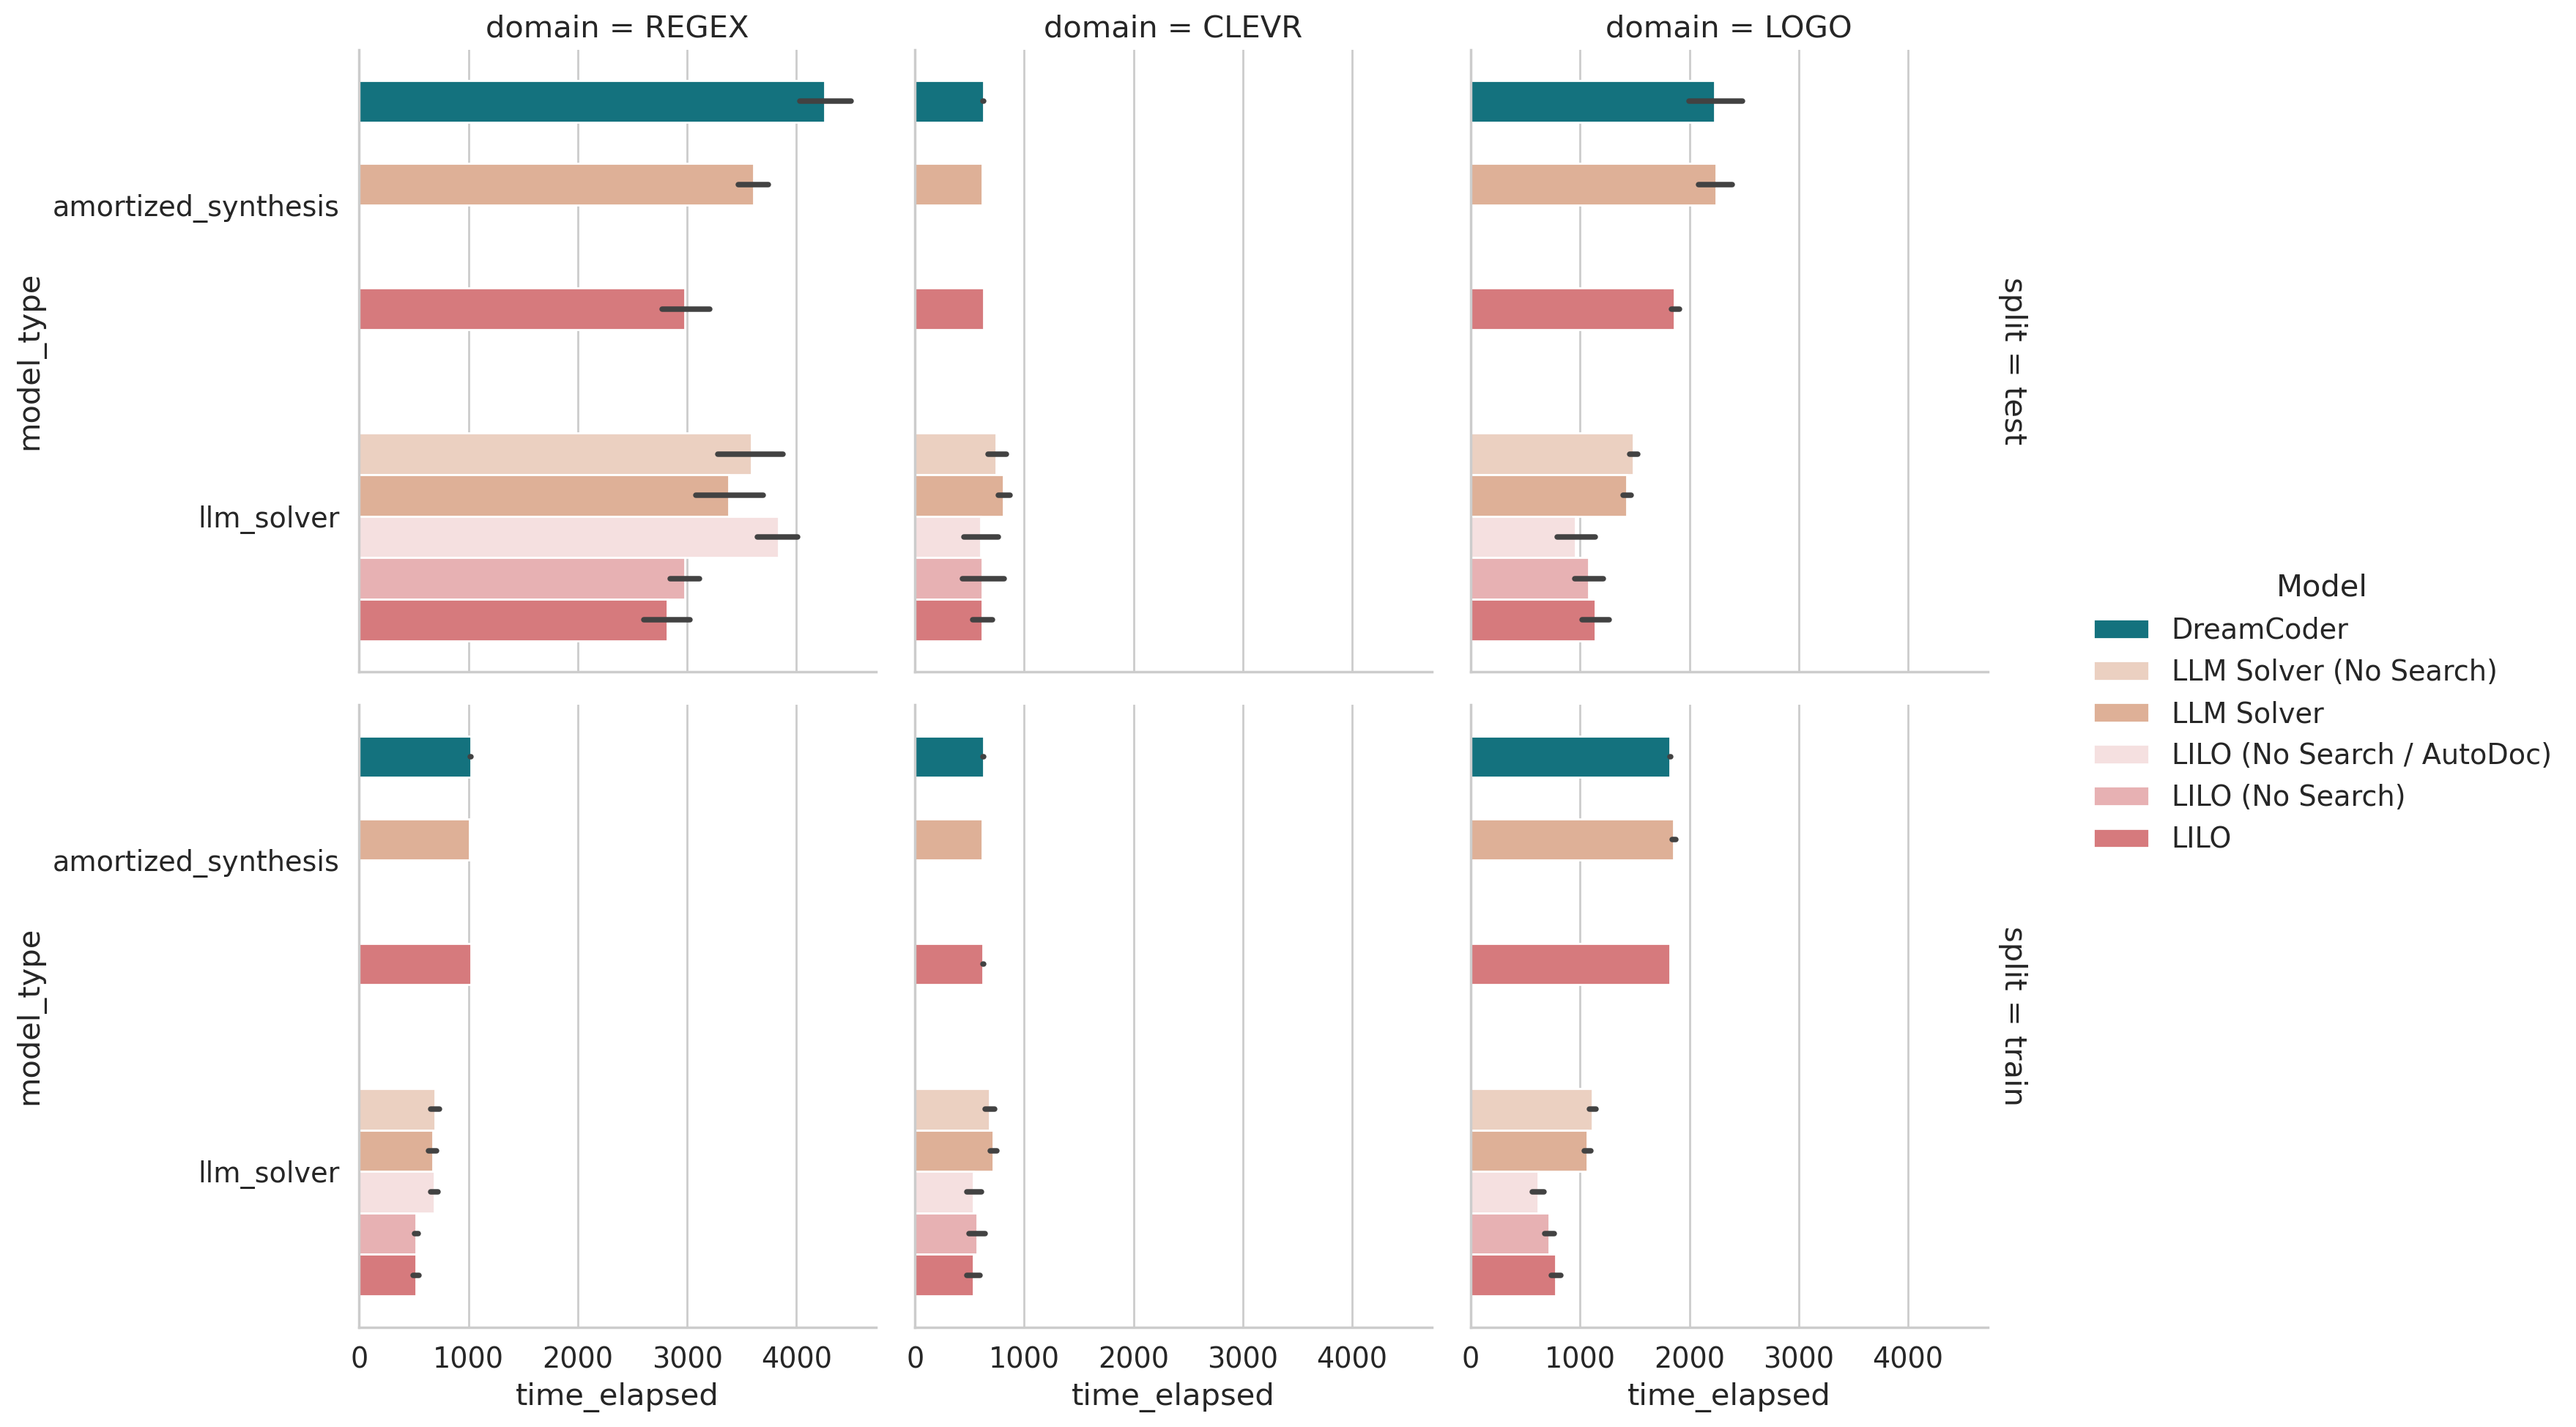

In [41]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="bar",
    col="domain",
    row="split",
    y="model_type",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
    sharex=True,
    # facet_kws=dict(sharex=True,)
    
)

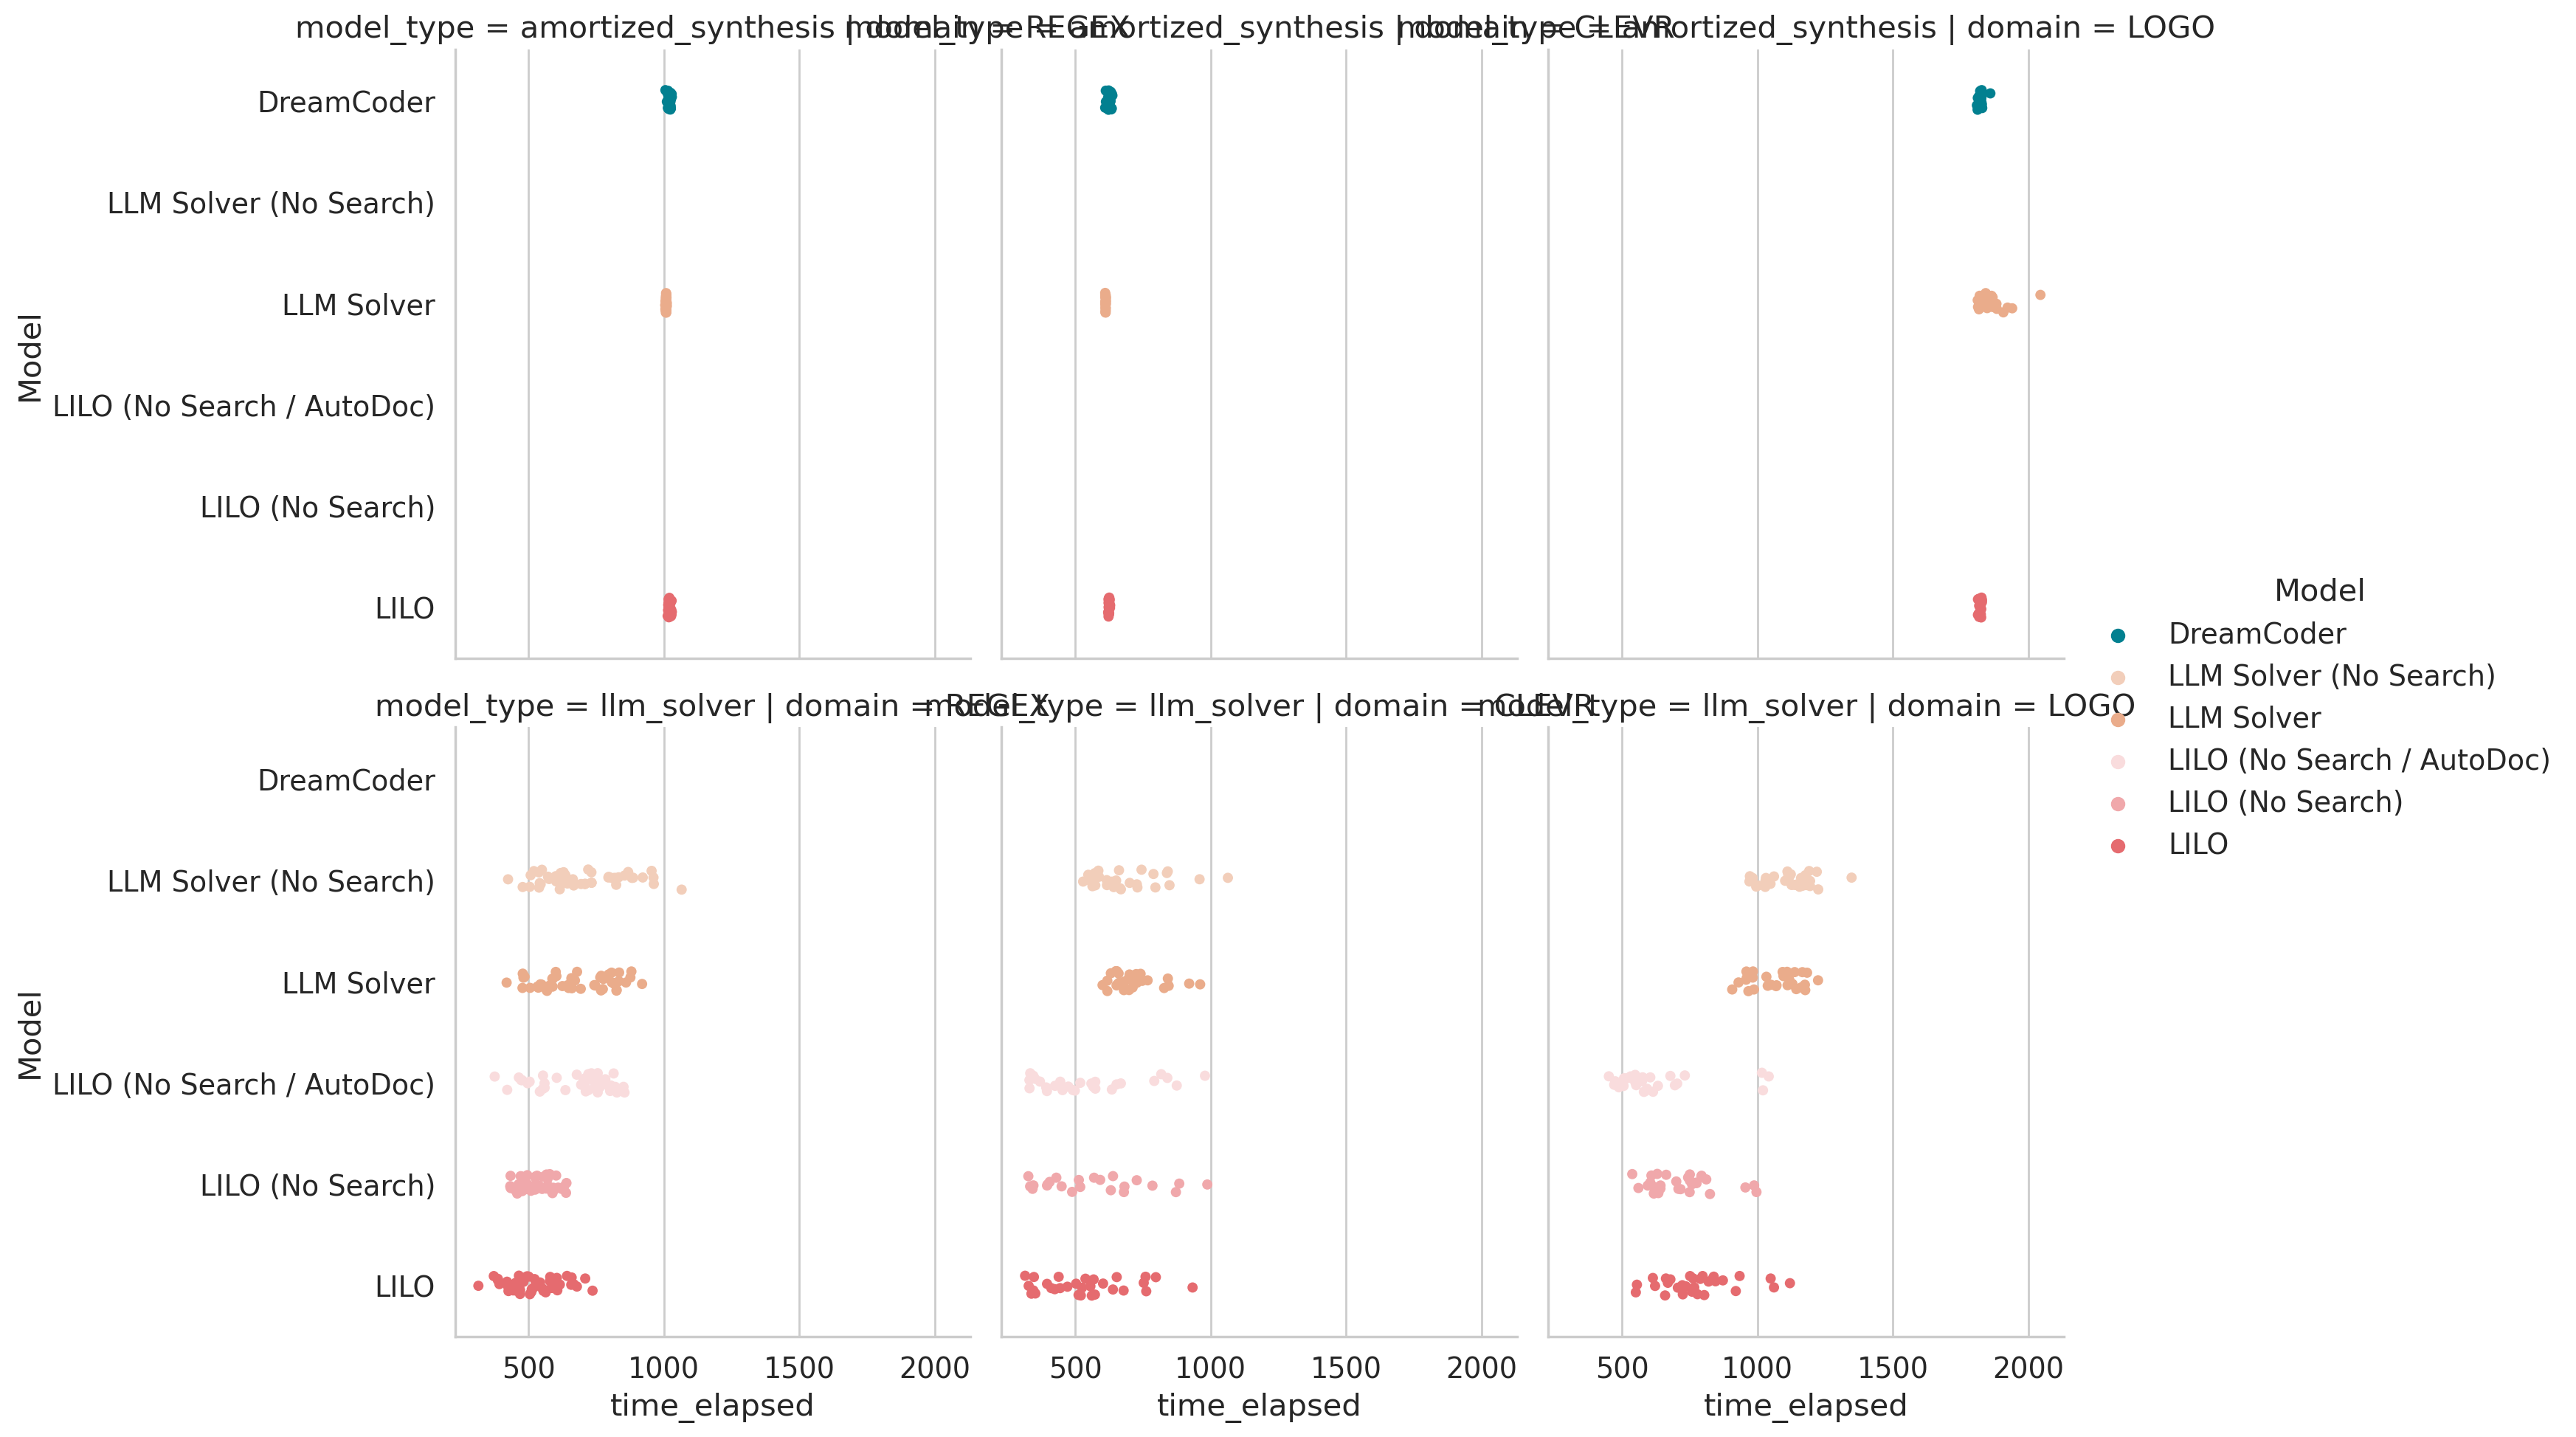

In [42]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs.query("split == 'train'")), 
    kind="strip",
    col="domain",
    row="model_type",
    y=analyzer.COL_NAMES_CAMERA["experiment_type"],
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
    sharex=True,
    # facet_kws=dict(sharex=True,)
    
)

# Number of queries

In [43]:
# Cache these results since they take a long time to load
TOKEN_USAGE_PATH = "token_usage.csv"

if not os.path.exists(TOKEN_USAGE_PATH):
    df_token_usage = analyzer.get_gpt_solver_results()
    df_token_usage.to_csv("token_usage.csv", index=False)
else:
    df_token_usage = pd.read_csv(TOKEN_USAGE_PATH)

In [44]:
df_token_usage

,prompt_tokens,completion_tokens,total_tokens,domain,experiment_type,seed,iteration,split,task_id,query_i
0,1460,206,1666,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,0
1,1463,195,1658,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,1
2,1462,232,1694,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,2
3,1460,183,1643,re2,gpt_solver,111,0,train,re2_train_489_if_there_is_any_letter_consonant...,3
4,1461,184,1645,re2,gpt_solver,111,0,train,re2_train_153_if_there_is_consonant_consonant_...,0
...,...,...,...,...,...,...,...,...,...,...
277536,3882,338,4220,logo,gpt_solver_stitch_namer_search,333,9,test,6 sided snowflake with a short space and a sho...,3
277537,3935,151,4086,logo,gpt_solver_stitch_namer_search,333,9,test,5 sided snowflake with 2 small 5 gon s as arms,0
277538,3830,222,4052,logo,gpt_solver_stitch_namer_search,333,9,test,5 sided snowflake with 2 small 5 gon s as arms,1
277539,3767,374,4141,logo,gpt_solver_stitch_namer_search,333,9,test,5 sided snowflake with 2 small 5 gon s as arms,2


In [45]:
df_token_usage_by_iteration = df_token_usage.groupby([
    "domain",
    "experiment_type",
    "split",
    "seed",
    "iteration"
]) \
[["prompt_tokens", "completion_tokens", "total_tokens"]] \
.sum().reset_index()

df_token_usage_by_iteration

,domain,experiment_type,split,seed,iteration,prompt_tokens,completion_tokens,total_tokens
0,clevr,gpt_solver,test,111,0,1290850,87360,1378210
1,clevr,gpt_solver,test,111,3,770686,76143,846829
2,clevr,gpt_solver,test,111,6,660547,82898,743445
3,clevr,gpt_solver,test,111,9,582015,78061,660076
4,clevr,gpt_solver,test,222,0,1161136,70582,1231718
...,...,...,...,...,...,...,...,...
745,re2,gpt_solver_stitch_namer_search,train,333,11,916229,37347,953576
746,re2,gpt_solver_stitch_namer_search,train,333,12,749141,29384,778525
747,re2,gpt_solver_stitch_namer_search,train,333,13,787686,34425,822111
748,re2,gpt_solver_stitch_namer_search,train,333,14,880818,36147,916965


In [46]:
analyzer.format_dataframe_camera(df_token_usage_by_iteration.query("split == 'train'"))

,domain,Model,split,seed,iteration,prompt_tokens,completion_tokens,total_tokens
438,REGEX,LLM Solver (No Search),train,111,0,420499,58326,478825
439,REGEX,LLM Solver (No Search),train,111,1,763250,67007,830257
440,REGEX,LLM Solver (No Search),train,111,2,960253,72747,1033000
441,REGEX,LLM Solver (No Search),train,111,3,984600,77153,1061753
442,REGEX,LLM Solver (No Search),train,111,4,839914,70389,910303
...,...,...,...,...,...,...,...,...
415,LOGO,LILO,train,333,5,1162170,78290,1240460
416,LOGO,LILO,train,333,6,1047793,60812,1108605
417,LOGO,LILO,train,333,7,1055473,67768,1123241
418,LOGO,LILO,train,333,8,791713,40193,831906


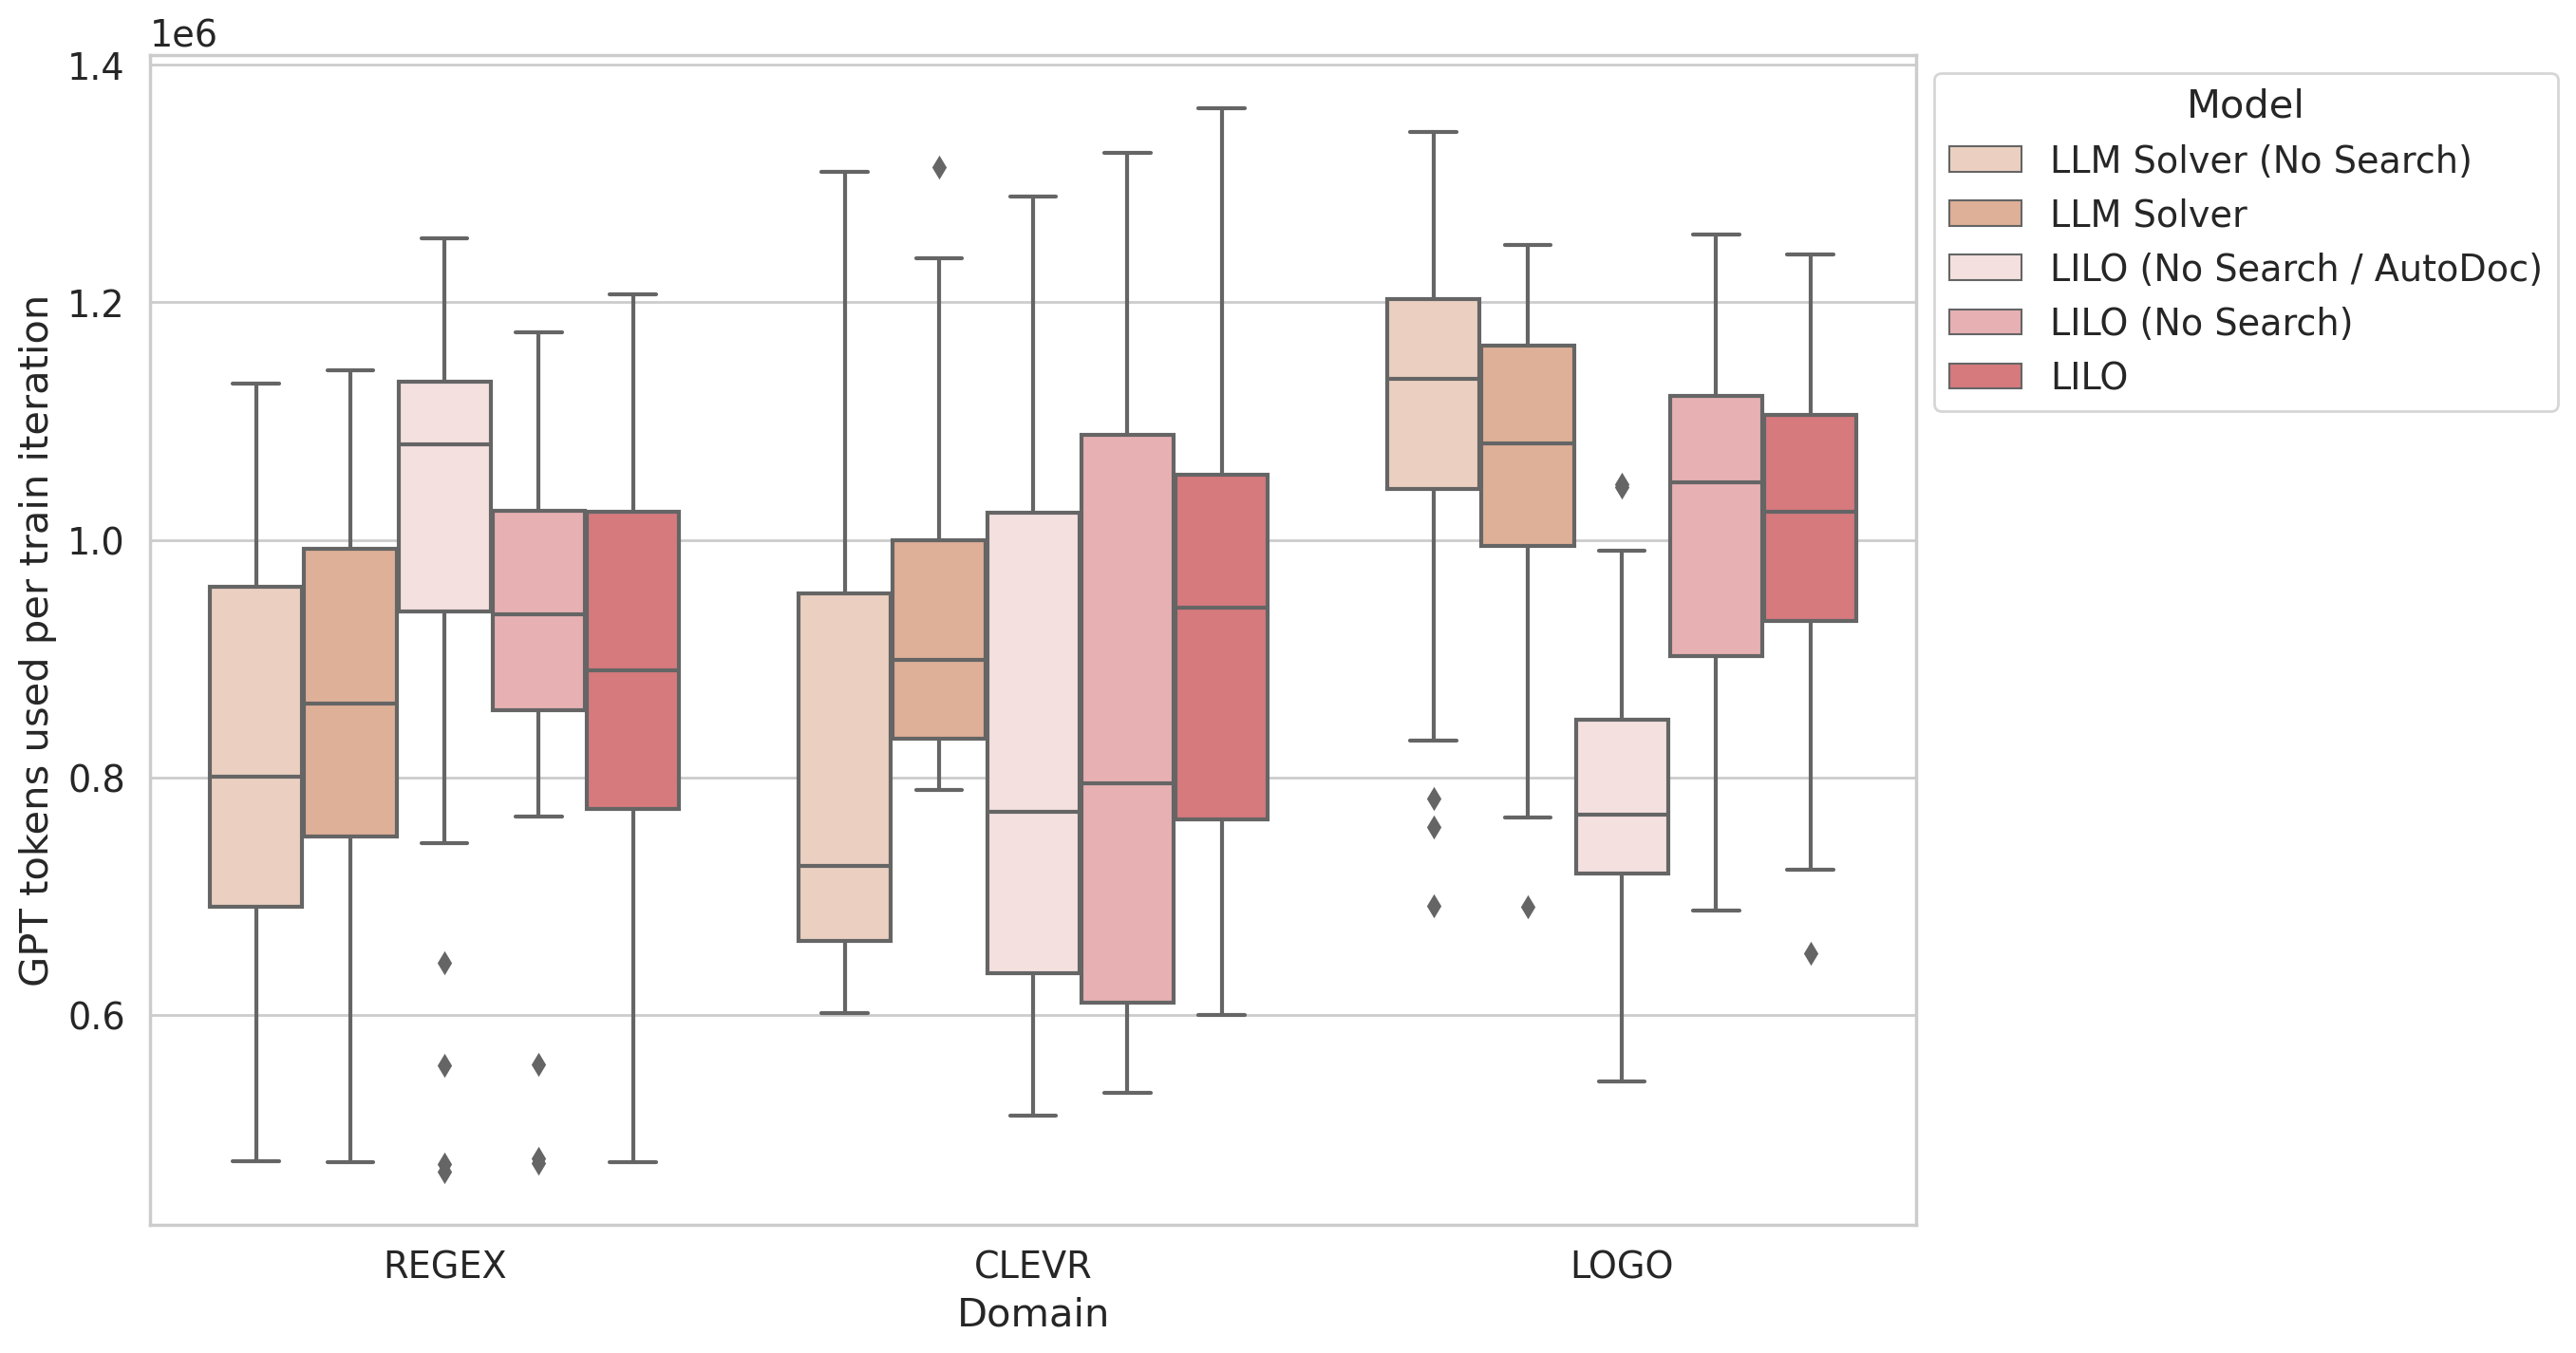

In [47]:
ax = sns.boxplot(
    data=analyzer.format_dataframe_camera(df_token_usage_by_iteration.query("split == 'train'")), 
    y="total_tokens",
    x="domain",
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
)
ax.set_ylabel("GPT tokens used per train iteration")
ax.set_xlabel("Domain")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(os.path.join(FIGURES_DIR, "token_usage.pdf"), dpi=300, bbox_inches="tight")

# Dollar cost table

In [48]:
df_token_usage_stats = df_token_usage.query("split == 'train'").groupby([
    "domain",
    "experiment_type",
    "seed",
    "iteration"
]) \
[["total_tokens"]] \
.sum().reset_index()

df_token_usage_stats = df_token_usage_stats.groupby([
    "domain",
    "experiment_type",
]) \
[["total_tokens"]] \
.agg(["mean", "std"]).reset_index()

df_token_usage_stats[("cost", "mean")] = (0.002 / 1000) * df_token_usage_stats["total_tokens"]["mean"]
df_token_usage_stats[("cost", "std")] = (0.002 / 1000) * df_token_usage_stats["total_tokens"]["std"]

# Drop total tokens
df_token_usage_stats = df_token_usage_stats[["domain", "experiment_type", "cost"]]

df_token_usage_stats

domain                 experiment_type      cost          
                                               mean       std
0   clevr                      gpt_solver  1.662261  0.435939
1   clevr               gpt_solver_search  1.881679  0.290583
2   clevr               gpt_solver_stitch  1.662688  0.471845
3   clevr         gpt_solver_stitch_namer  1.701005  0.521042
4   clevr  gpt_solver_stitch_namer_search  1.865970  0.418131
5    logo                      gpt_solver  2.193114  0.317582
6    logo               gpt_solver_search  2.128892  0.300710
7    logo               gpt_solver_stitch  1.585315  0.240222
8    logo         gpt_solver_stitch_namer  2.029652  0.310121
9    logo  gpt_solver_stitch_namer_search  2.011322  0.297350
10    re2                      gpt_solver  1.646017  0.349959
11    re2               gpt_solver_search  1.697713  0.327916
12    re2               gpt_solver_stitch  2.038254  0.392807
13    re2         gpt_solver_stitch_namer  1.856264  0.303634
14    re2  gpt_solver_stitch_namer_search  1.766567  0.376823

In [49]:
# Convert to table
df_token_usage_stats_table = analyzer.format_dataframe_camera(df_token_usage_stats)


df_token_usage_stats_table = df_token_usage_stats_table.pivot(index=analyzer.COL_NAMES_CAMERA["experiment_type"], columns="domain")

df_token_usage_stats_table = df_token_usage_stats_table.reorder_levels(order=[0, 2, 1], axis="columns")

multiindex = df_token_usage_stats_table.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["mean", "std"], level=2)[0]

df_token_usage_stats_table = df_token_usage_stats_table.reindex(columns=multiindex)
df_token_usage_stats_table.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_token_usage_stats_table.index]
df_token_usage_stats_table = df_token_usage_stats_table.reindex(experiment_types)

# Remove 'Model'
df_token_usage_stats_table.index.name = None

# Round numbers
df_token_usage_stats_table = df_token_usage_stats_table.round(2)

# Drop 'cost'
# df_token_usage_stats_table = df_token_usage_stats_table.droplevel(level=0, axis=1)

# Format each entry as a dollar value
df_token_usage_stats_table = df_token_usage_stats_table.applymap(lambda x: '${:,.2f}'.format(x) if isinstance(x, (int, float)) else x)


# Output to LaTeX
df_token_usage_stats_table.to_latex(os.path.join(FIGURES_DIR, "token_cost_table.tex"))

df_token_usage_stats_table

cost                                   
                            REGEX         CLEVR          LOGO       
                             mean    std   mean    std   mean    std
LLM Solver (No Search)      $1.65  $0.35  $1.66  $0.44  $2.19  $0.32
LLM Solver                  $1.70  $0.33  $1.88  $0.29  $2.13  $0.30
LILO (No Search / AutoDoc)  $2.04  $0.39  $1.66  $0.47  $1.59  $0.24
LILO (No Search)            $1.86  $0.30  $1.70  $0.52  $2.03  $0.31
LILO                        $1.77  $0.38  $1.87  $0.42  $2.01  $0.30

In [53]:
df_search_stats = df_infer_programs \
.query("experiment_type == 'baseline_dreamcoder' or experiment_type == 'gpt_solver_search' or experiment_type == 'gpt_solver_stitch_namer_search'") \
.query("split == 'train'") \
.query("model_type == 'amortized_synthesis'") \
[["domain", "experiment_type", "seed", "iteration", "time_elapsed"]]

df_search_stats = df_search_stats.groupby([
    "domain",
    "experiment_type",
]) \
[["time_elapsed"]] \
.agg(["mean", "std"]).reset_index()

df_search_stats[("cost", "mean")] = (4.08 / (60*60)) * df_search_stats["time_elapsed"]["mean"]
df_search_stats[("cost", "std")] = (4.08 / (60*60)) * df_search_stats["time_elapsed"]["std"]

# Drop elapsed time
df_search_stats = df_search_stats[["domain", "experiment_type", "cost"]]


df_search_stats

domain                 experiment_type      cost          
                                              mean       std
0  clevr             baseline_dreamcoder  0.709911  0.007381
1  clevr               gpt_solver_search  0.693688  0.000669
2  clevr  gpt_solver_stitch_namer_search  0.708299  0.002152
3   logo             baseline_dreamcoder  2.068901  0.009300
4   logo               gpt_solver_search  2.105251  0.057278
5   logo  gpt_solver_stitch_namer_search  2.065819  0.004783
6    re2             baseline_dreamcoder  1.156587  0.005212
7    re2               gpt_solver_search  1.142860  0.001251
8    re2  gpt_solver_stitch_namer_search  1.156620  0.004268

In [54]:
# Convert to table
df_search_stats_table = analyzer.format_dataframe_camera(df_search_stats)


df_search_stats_table = df_search_stats_table.pivot(index=analyzer.COL_NAMES_CAMERA["experiment_type"], columns="domain")

df_search_stats_table = df_search_stats_table.reorder_levels(order=[0, 2, 1], axis="columns")

multiindex = df_search_stats_table.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["mean", "std"], level=2)[0]

df_search_stats_table = df_search_stats_table.reindex(columns=multiindex)
df_search_stats_table.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_search_stats_table.index]
df_search_stats_table = df_search_stats_table.reindex(experiment_types)

# Remove 'Model'
df_search_stats_table.index.name = None

# Round numbers
df_search_stats_table = df_search_stats_table.round(2)

# Drop 'cost'
# df_search_stats_table = df_search_stats_table.droplevel(level=0, axis=1)

# Format each entry as a dollar value
df_search_stats_table = df_search_stats_table.applymap(lambda x: '${:,.2f}'.format(x) if isinstance(x, (int, float)) else x)


# Output to LaTeX
df_search_stats_table.to_latex(os.path.join(FIGURES_DIR, "search_cost_table.tex"))

df_search_stats_table

cost                                   
            REGEX         CLEVR          LOGO       
             mean    std   mean    std   mean    std
DreamCoder  $1.16  $0.01  $0.71  $0.01  $2.07  $0.01
LLM Solver  $1.14  $0.00  $0.69  $0.00  $2.11  $0.06
LILO        $1.16  $0.00  $0.71  $0.00  $2.07  $0.00

In [55]:
df_cost_table = pd.concat([df_token_usage_stats_table, df_search_stats_table], keys=['LLM Search', 'Enumerative Search'])

# Output to LaTeX
df_cost_table.to_latex(os.path.join(FIGURES_DIR, "cost_table.tex"))

df_cost_table

cost                       \
                                               REGEX         CLEVR          
                                                mean    std   mean    std   
LLM Search         LLM Solver (No Search)      $1.65  $0.35  $1.66  $0.44   
                   LLM Solver                  $1.70  $0.33  $1.88  $0.29   
                   LILO (No Search / AutoDoc)  $2.04  $0.39  $1.66  $0.47   
                   LILO (No Search)            $1.86  $0.30  $1.70  $0.52   
                   LILO                        $1.77  $0.38  $1.87  $0.42   
Enumerative Search DreamCoder                  $1.16  $0.01  $0.71  $0.01   
                   LLM Solver                  $1.14  $0.00  $0.69  $0.00   
                   LILO                        $1.16  $0.00  $0.71  $0.00   

                                                             
                                                LOGO         
                                                mean    std  
LLM Search         LLM Solver (No Search)      $2.19  $0.32  
                   LLM Solver                  $2.13  $0.30  
                   LILO (No Search / AutoDoc)  $1.59  $0.24  
                   LILO (No Search)            $2.03  $0.31  
                   LILO                        $2.01  $0.30  
Enumerative Search DreamCoder                  $2.07  $0.01  
                   LLM Solver                  $2.11  $0.06  
                   LILO                        $2.07  $0.00